# Packages

In [112]:
import os
import sys
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorchcv.model_provider import get_model as ptcv_get_model
from torch.autograd import Variable

device = "cuda"

# Utilities

### Denormalization

In [49]:
def denorm(batch, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Get Cifar-100 classes

In [284]:
cifar100_classes =['Apple',
 'Aquarium_fish',
 'Baby',
 'Bear',
 'Beaver',
 'Bed',
 'Bee',
 'Beetle',
 'Bicycle',
 'Bottle',
 'Bowl',
 'Boy',
 'Bridge',
 'Bus',
 'Butterfly',
 'Camel',
 'Can',
 'Castle',
 'Caterpillar',
 'Cattle',
 'Chair',
 'Chimpanzee',
 'Clock',
 'Cloud',
 'Cockroach',
 'Couch',
 'Crab',
 'Crocodile',
 'Cup',
 'Dinosaur',
 'Dolphin',
 'Elephant',
 'Flatfish',
 'Forest',
 'Fox',
 'Girl',
 'Hamster',
 'House',
 'Kangaroo',
 'Keyboard',
 'Lamp',
 'Lawn_mower',
 'Leopard',
 'Lion',
 'Lizard',
 'Lobster',
 'Man',
 'Maple_tree',
 'Motorcycle',
 'Mountain',
 'Mouse',
 'Mushroom',
 'Oak_tree',
 'Orange',
 'Orchid',
 'Otter',
 'Palm_tree',
 'Pear',
 'Pickup_truck',
 'Pine_tree',
 'Plain',
 'Plate',
 'Poppy',
 'Porcupine',
 'Possum',
 'Rabbit',
 'Raccoon',
 'Ray',
 'Road',
 'Rocket',
 'Rose',
 'Sea',
 'Seal',
 'Shark',
 'Shrew',
 'Skunk',
 'Skyscraper',
 'Snail',
 'Snake',
 'Spider',
 'Squirrel',
 'Streetcar',
 'Sunflower',
 'Sweet_pepper',
 'Table',
 'Tank',
 'Telephone',
 'Television',
 'Tiger',
 'Tractor',
 'Train',
 'Trout',
 'Tulip',
 'Turtle',
 'Wardrobe',
 'Whale',
 'Willow_tree',
 'Wolf',
 'Woman',
 'Worm']

def get_cifar100_class(class_number):
    if class_number >= 0 and class_number < len(cifar100_classes):
        return cifar100_classes[class_number]
    else:
        return "Invalid class number"

# Load the dataset

### Load images & labels

In [247]:
eval200_folder = "/home/adl/Desktop/zenn/SPML/HW2/eval_200"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
tensor_images = []
file_names = []
for filename in os.listdir(eval200_folder):
    if filename.endswith('.png'):  
        image_path = os.path.join(eval200_folder, filename)
        image = Image.open(image_path).convert('RGB')  
        tensor_image = transform(image).to(device)  
        tensor_images.append(tensor_image)  
        file_names+=[filename]
print(f'image example:\n{tensor_images[0]}')

eval_labels = []
eval_labels_loaded = np.load('/home/adl/Desktop/zenn/SPML/HW2/labels_200.npy')
for i in range(len(eval_labels_loaded)):
    eval_labels.append(torch.tensor(eval_labels_loaded[i]).to(device))
print(f'label example:\n{eval_labels[0]}')

batch_size = 64
batch_images = []
batch_labels = []
batch_targets = []
target = eval_labels[159]
target_labels = [target]*500
for i in range(0, len(tensor_images), batch_size):
    batch_images.append(torch.stack(tensor_images[i:i+batch_size]))
    batch_labels.append(torch.tensor(eval_labels[i:i+batch_size]))
    batch_targets.append(torch.tensor(target_labels[i:i+batch_size]))

image example:
tensor([[[-0.8902, -0.9294, -0.9294,  ...,  1.0000,  0.9843,  0.9765],
         [-0.8510, -0.8275, -0.8510,  ...,  0.7961,  0.8510,  0.9843],
         [-0.7176, -0.7804, -0.8510,  ...,  0.4275,  0.7176,  0.9765],
         ...,
         [ 0.3333,  0.3647,  0.3961,  ...,  0.2157,  0.3020,  0.2471],
         [ 0.3098,  0.3098,  0.3412,  ...,  0.2392,  0.3020,  0.2706],
         [ 0.2706,  0.2784,  0.2706,  ...,  0.1686,  0.2235,  0.2706]],

        [[-0.8196, -0.9216, -0.9059,  ...,  1.0000,  0.9922,  0.9922],
         [-0.7804, -0.7961, -0.8039,  ...,  0.7961,  0.8118,  0.9922],
         [-0.6627, -0.6941, -0.8118,  ...,  0.4196,  0.6235,  0.9451],
         ...,
         [ 0.3647,  0.3804,  0.4196,  ...,  0.2157,  0.2941,  0.2235],
         [ 0.3333,  0.3176,  0.3569,  ...,  0.2314,  0.2706,  0.2392],
         [ 0.2863,  0.2863,  0.2863,  ...,  0.1686,  0.2157,  0.2392]],

        [[-0.8824, -0.9216, -0.9137,  ...,  0.8510,  0.9294,  0.9451],
         [-0.8275, -0.8118, -0

# Models

In [281]:
model_name = "resnet20" 
model = ptcv_get_model(f"{model_name}_cifar100", pretrained=True).to(device).eval()
print(model)

CIFARResNet(
  (features): Sequential(
    (init_block): ConvBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBlock(
          (conv1): ConvBlock(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): ConvBlock(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (activ): ReLU(inplace=True)
      )
      (unit2): ResUnit(
        (body): ResBlock(
          (co

# Find UAP

In [252]:
def UAP(epsilon,alpha,iterations):   
    
    perturbation = torch.rand_like(tensor_images[0], device=device)
    perturbation.requires_grad = True  
    
    for iter in range(iterations):
        if iter % 15 == 0:  
            alpha *= 0.7  
        for inputs, targets in zip(tensor_images, eval_labels):
            inputs, targets = inputs.to(device), targets.to(device)
            perturbed_inputs = inputs + perturbation
            perturbed_inputs.clamp_(-1, 1)
            outputs = model(perturbed_inputs.unsqueeze(0))

            loss = nn.CrossEntropyLoss()(outputs, targets)  
            loss.backward()
            
            with torch.no_grad():
                perturbation.grad.sign_()
                perturbation.data.add_(alpha * perturbation.grad)
                perturbation.data.clamp_(-epsilon, epsilon)
            perturbation.grad.zero_()
    
    perturbation = perturbation.detach()        
    
    return perturbation

In [195]:
def find_best_UAP(try_times,epsilon,alpha,iterations):
    min_accuracy = 100
    best_perturbation = torch.rand_like(tensor_images[0], device=device)
    for t in range(try_times):
        correct = 0
        total = 0
        perturbation = UAP(epsilon,alpha,iterations)
        for images, labels in zip(batch_images, batch_labels):
            perturbed_images = images.to(device)+perturbation
            perturbed_images.clamp_(-1, 1)
            labels = labels.to(device)
            
            outputs = model(perturbed_images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f'Try times: {t+1}, ','Accuracy: {:.2f}%'.format(accuracy))
        if accuracy<min_accuracy:
            min_accuracy = accuracy
            print(f'\nMin Accuracy: {min_accuracy}%\n')
            best_perturbation = perturbation
    return best_perturbation

In [253]:
try_times = 5
epsilon = 12/255  
alpha = 4/255  
iterations = 150  

perturbation = find_best_UAP(try_times,epsilon,alpha,iterations)

Try times: 1,  Accuracy: 3.50%

Min Accuracy: 3.5%

Try times: 2,  Accuracy: 4.00%
Try times: 3,  Accuracy: 3.50%
Try times: 4,  Accuracy: 3.50%
Try times: 5,  Accuracy: 4.50%


In [254]:
print(perturbation)

tensor([[[-0.0466, -0.0471, -0.0471,  ..., -0.0197,  0.0091, -0.0462],
         [ 0.0471,  0.0448, -0.0453,  ..., -0.0466,  0.0409,  0.0462],
         [-0.0471, -0.0471,  0.0084,  ...,  0.0462, -0.0409,  0.0471],
         ...,
         [-0.0462,  0.0471,  0.0435,  ...,  0.0448, -0.0466, -0.0471],
         [-0.0453, -0.0444,  0.0466,  ..., -0.0466,  0.0466, -0.0448],
         [ 0.0471, -0.0466,  0.0011,  ...,  0.0471, -0.0466, -0.0471]],

        [[-0.0471, -0.0426,  0.0453,  ...,  0.0471,  0.0466,  0.0462],
         [-0.0320,  0.0448, -0.0426,  ..., -0.0471,  0.0457,  0.0457],
         [ 0.0466,  0.0462,  0.0471,  ...,  0.0223, -0.0413,  0.0471],
         ...,
         [-0.0435,  0.0471, -0.0466,  ...,  0.0457, -0.0457,  0.0457],
         [-0.0462, -0.0462,  0.0471,  ..., -0.0471,  0.0471,  0.0471],
         [ 0.0471, -0.0466,  0.0448,  ...,  0.0462,  0.0444,  0.0457]],

        [[ 0.0466,  0.0471,  0.0466,  ..., -0.0471, -0.0471, -0.0462],
         [-0.0435,  0.0471, -0.0444,  ..., -0

# Save UAP to PNG

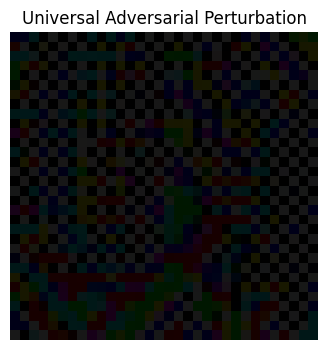

In [255]:
perturbation = (perturbation*255+12)/255
UAP_image = transforms.ToPILImage()(perturbation.squeeze())
plt.figure(figsize=(8,4)) 
plt.axis('off')
plt.title('Universal Adversarial Perturbation')
plt.imshow(UAP_image)
UAP_image.save(f'/home/adl/Desktop/zenn/SPML/HW2/universarial.png', 'PNG')

# Test 

### Load UAP

UAP Loaded


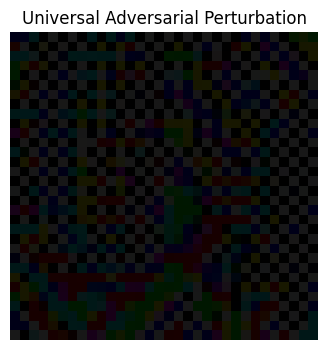

In [288]:
transform = transforms.Compose([
    transforms.ToTensor()  
])

image_path = "/home/adl/Desktop/zenn/SPML/HW2/universarial.png"  
image = Image.open(image_path).convert('RGB')  

perturbation_image_tensor = transform(image)

perturbation_image_tensor = (perturbation_image_tensor*255-12)/255
perturbation_image_tensor = perturbation_image_tensor.to(device)

print('UAP Loaded')

plt.figure(figsize=(8,4)) 
plt.axis('off')
plt.title('Universal Adversarial Perturbation')
plt.imshow(image)

### Evaluate

In [289]:
target = eval_labels[159]
target_labels = [target]*500
    
correct = 0
total = 0

ex_images_tensors = []
ex_adv_images_tensors = []
ex_labels_tensors = []
ex_preds_tensors = []

for images, labels in zip(batch_images, batch_labels):
    perturbed_images = images.to(device)+perturbation_image_tensor
    perturbed_images.clamp_(-1, 1)
    labels = labels.to(device)
    
    outputs = model(perturbed_images)
    preds = torch.argmax(outputs, dim=1)

    correct += (preds == labels).sum().item()
    total += labels.size(0)
    
    # Save some examples
    for x in range(3):
        if labels[x] != preds[x]:
            ex_images_tensors.append(images[x])
            ex_adv_images_tensors.append(perturbed_images[x])
            ex_labels_tensors.append(labels[x])
            ex_preds_tensors.append(preds[x])
   
accuracy = 100 * correct / total
print(f'{model_name} Accuracy: {accuracy}%'.format(accuracy))


resnet20 Accuracy: 3.5%


# Result

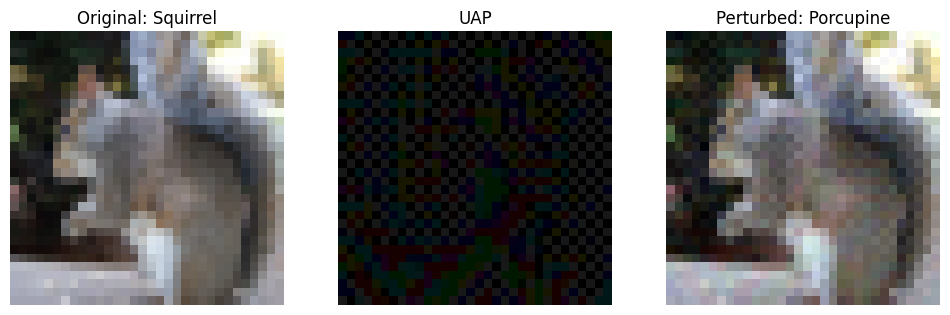

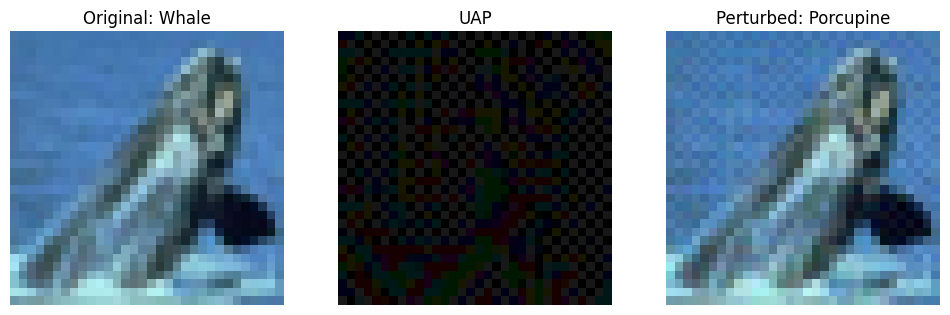

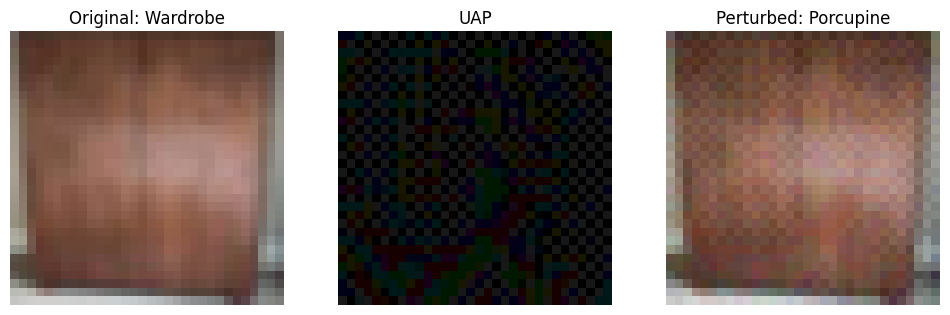

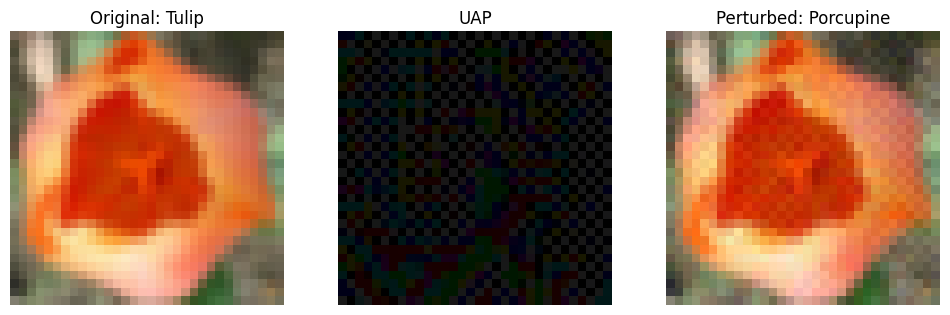

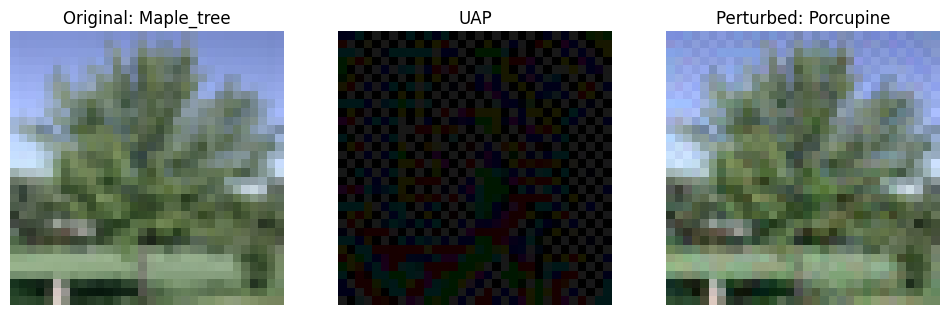

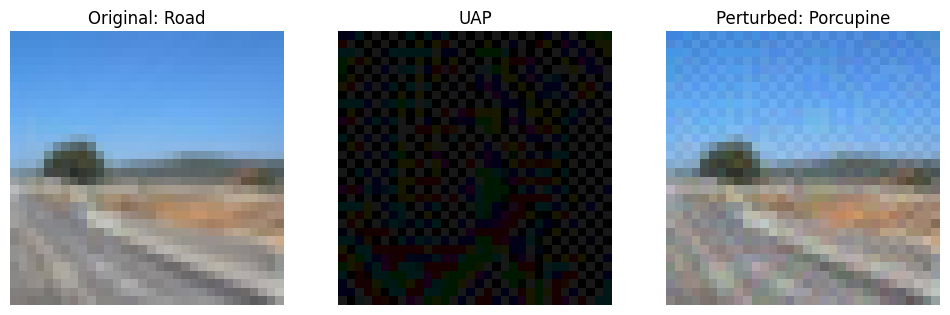

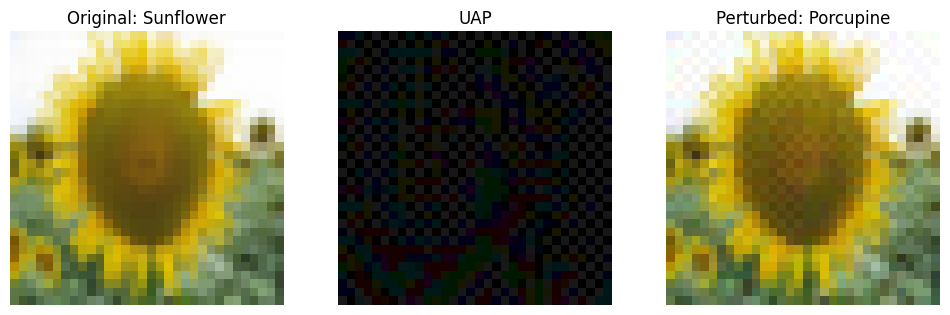

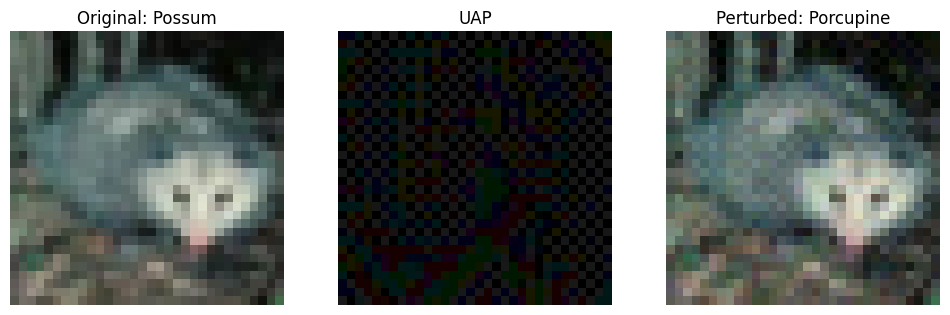

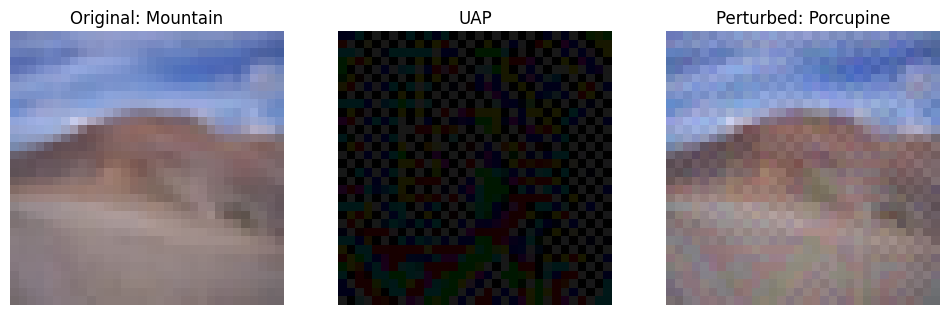

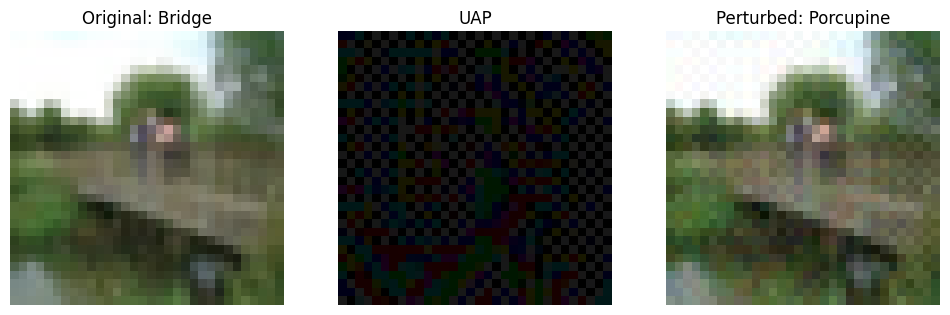

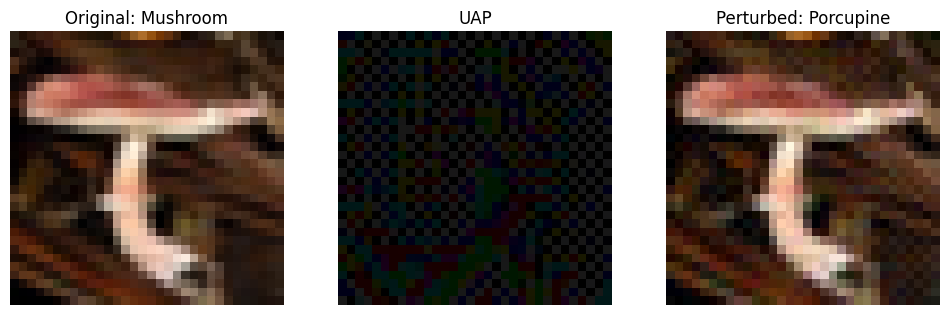

In [287]:
for ex_image_tensor, ex_adv_image_tensor, ex_label_tensor, ex_pred_tensor in zip(ex_images_tensors, ex_adv_images_tensors, ex_labels_tensors, ex_preds_tensors):
    denorm_ex_images_tensor = denorm(ex_image_tensor)
    ex_image = transforms.ToPILImage()(denorm_ex_images_tensor.squeeze())
    denorm_ex_adv_images_tensor = denorm(ex_adv_image_tensor)
    ex_adv_image = transforms.ToPILImage()(denorm_ex_adv_images_tensor.squeeze())
    ex_label = get_cifar100_class(int(ex_label_tensor))
    ex_pred = get_cifar100_class(int(ex_pred_tensor))
    
    plt.figure(figsize=(12,4)) 
    
    plt.subplot(131)
    plt.axis('off')
    plt.title(f'Original: {ex_label}')
    plt.imshow(ex_image)
    
    plt.subplot(132)
    plt.axis('off')
    plt.title('UAP')
    plt.imshow(image)
    
    plt.subplot(133) 
    plt.axis('off')
    plt.title(f'Perturbed: {ex_pred}')
    plt.imshow(ex_adv_image)